# The battle of the neighborhoods

## Introduction/Business Problem

People love to move from one place to another be it for a short vacation or their permanent dream retirement. At the time of moving in to a new place they usually need a lot of comparative analysis for affordable housing prices, nearby resturants, Cafe, School, malls, pharmacy shops, grocery shops, theatre, hospital, etc.

This Capstone Project will save both time and money (and obviously efforts lol) of the user and give an optimal solution.

This project will be helpful to the user at the time he/she wants to buy/rent a house based on the facilities available around the neighborhood. For demonstration, I'll be comparing 2 random neighborhoods and analyse the top common places in the neighborhood based on the number of people visiting them.

For that, this project will be using Foursquare API that will provide us location based experiences with diverse information about venues, users, photos, and check-ins. Also I'll be using K-mean clustering algorithm to cluster the venues based on the places such as park, gym, theatre etc. 

At the end of our project, we will be having a better understanding about both the neighborhoods and with the help of data insights we can conclude which one to choose.

## Data Section

• Foursquare API:
The Foursquare API has a database of more than 105 million places. This Capstone Project will be using Foursquare API as its prime data gathering source. This API will help us to perform location search, location sharing and details about a business. Foursquare users can also use photos, tips and reviews in many productive ways to add value to the results.

• K-mean clustering algorithm will be applied to form the clusters of different categories of places residing in and around the neighborhoods. These clusters from each of those two random neighborhoods will be analyzed individually collectively and comparatively to derive the conclusions.

• Work Flow:
HTTP requests would be made to the Foursquare API server using zip codes of the random neighborhoods to pull the location information (Latitudes and Longitudes). Due to http request limitations the number of places per neighborhood parameter would reasonably be set to 100 and the radius parameter would be set to 700.

## Libraries to be used

• Pandas - For data analysis and manipulation

• NumPy – To compute data in vectorized manner

• Geopy – To locate coordinates of locations

• JSON – To handle JSON files

• Requests – To handle http requests

• Sklearn – For machine learning algorithms

• Matplotlib – For interactive visualization

• Folium – For map rendering

#### Importing Libraries

In [1]:
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import json
from geopy.geocoders import Nominatim 
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import folium

#### Retrieving the table with 3 columns: PostalCode, Borough, Neighborhood from the url

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'html')

table = soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

,PostalCode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


#### Removing "\n" from all the column values and Borough that are "Not assigned"

In [3]:
df["Borough"] = df["Borough"].str.replace("\n","")
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df=df[df['Borough']!='Not assigned']

df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Printing the number of rows and columns

In [4]:
print("Shape: ", df.shape)

Shape:  (103, 3)


#### Displaying the top 5 lines of the dataframe

In [5]:
df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Merging Latitudes and Longitudes with respect to the PostalCode in the dataframe

In [6]:
def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

geo_df=pd.read_csv('http://cocl.us/Geospatial_data')

geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
geo_merged = pd.merge(geo_df, df, on='PostalCode')

geo_merged.head()
geo_data=geo_merged[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]
geo_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [7]:
print('Scarborough has {} boroughs and {} neighborhoods.'.format(
        len(geo_data['Borough'].unique()),
        geo_data.shape[0]
    )
)

Scarborough has 10 boroughs and 103 neighborhoods.


#### Printing the coordinates of Scarborough, Canada

In [8]:
address = 'Scarborough,Canada'

geolocator = Nominatim(user_agent="your_name")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough,Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough,Canada are 43.773077, -79.257774.


#### Creating a map of Scarborough using the coordinate values

In [9]:
map_scarborough = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(geo_data['Latitude'], geo_data['Longitude'], geo_data['Neighborhood']):
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scarborough)  
    
map_scarborough

In [10]:
geo_data = geo_data[geo_data['Borough'] == 'Scarborough'].reset_index(drop=True)
geo_data.head()
geo_data.shape

(17, 5)

#### Integrating with the Foursquare API

In [11]:
CLIENT_ID = "VEHU14FUD3IM0AVIXMPQA1L103UZ2PTJT30F4MR4CRWUPFMF"
CLIENT_SECRET = "MEG0WGWEFILFOJHEXRULILWQPTQOWMDXVVXNMIIVQCWSANXP"
VERSION = 20200806

#### Creating a function to explore the nearby venues around the neighborhood

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [13]:
scarborough_venues = getNearbyVenues(names=geo_data['Neighborhood'],
                                   latitudes=geo_data['Latitude'],
                                   longitudes=geo_data['Longitude']
                                  )

Found 90 venues in 17 neighborhoods.


In [14]:
scarborough_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Birch Cliff, Cliffside West",4,4,4,4,4,4
Cedarbrae,8,8,8,8,8,8
"Clarks Corners, Tam O'Shanter, Sullivan",11,11,11,11,11,11
"Cliffside, Cliffcrest, Scarborough Village West",2,2,2,2,2,2


In [15]:
print('There are {} uniques categories.'.format(len(scarborough_venues['Venue Category'].unique())))


There are 55 uniques categories.


#### Printing the rows and columns of our current dataframe

In [16]:
print(scarborough_venues.shape)
scarborough_venues.head()

(90, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


#### Printing the total numbers of venues and categories in our dataframe

In [17]:
print('There are {} distinct venues in {} categories.'.format(
    len(scarborough_venues['Venue'].unique()),len(scarborough_venues['Venue Category'].unique())))


There are 80 distinct venues in 55 categories.


#### Analysing each of the neighborhood with respect to the facilities around it

In [18]:
# one hot encoding
scarborough_onehot = pd.get_dummies(scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
scarborough_onehot['Neighborhood'] = scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [scarborough_onehot.columns[-1]] + list(scarborough_onehot.columns[:-1])
scarborough_onehot = scarborough_onehot[fixed_columns]

scarborough_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,...,Playground,Rental Car Location,Restaurant,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Thai Restaurant,Vietnamese Restaurant,Women's Store
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each venue category

In [19]:
scarborough_grouped = scarborough_onehot.groupby('Neighborhood').mean().reset_index()
scarborough_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,...,Playground,Rental Car Location,Restaurant,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Thai Restaurant,Vietnamese Restaurant,Women's Store
0,Agincourt,0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0
1,"Birch Cliff, Cliffside West",0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0
2,Cedarbrae,0.0,0.0,0.125,0.0,0.125,0.125000,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.125000,0.0,0.0
3,"Clarks Corners, Tam O'Shanter, Sullivan",0.0,0.0,0.000,0.0,0.000,0.090909,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.090909,0.0,0.0
4,"Cliffside, Cliffcrest, Scarborough Village West",0.0,0.5,0.000,0.0,0.000,0.000000,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0


#### On the basis of the above observation now printing top 5 venues of each neighbourhood

In [20]:
num_top_venues = 5

for hood in scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = scarborough_grouped[scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant  0.25
1               Skating Rink  0.25
2             Breakfast Spot  0.25
3                     Lounge  0.25
4          Accessories Store  0.00


----Birch Cliff, Cliffside West----
                   venue  freq
0        College Stadium  0.25
1           Skating Rink  0.25
2  General Entertainment  0.25
3                   Café  0.25
4                   Park  0.00


----Cedarbrae----
                 venue  freq
0   Athletics & Sports  0.12
1  Fried Chicken Joint  0.12
2               Bakery  0.12
3                 Bank  0.12
4      Thai Restaurant  0.12


----Clarks Corners, Tam O'Shanter, Sullivan----
                 venue  freq
0          Pizza Place  0.18
1    Convenience Store  0.09
2   Chinese Restaurant  0.09
3          Gas Station  0.09
4  Fried Chicken Joint  0.09


----Cliffside, Cliffcrest, Scarborough Village West----
                 venue  freq
0  American Restaurant   0.5
1             

#### This function will sort the venues in descending order

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating a fresh dataframe to display the top ten venues for each neighborhood

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = scarborough_grouped['Neighborhood']

for ind in np.arange(scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Latin American Restaurant,Breakfast Spot,Lounge,Women's Store,College Stadium,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint
1,"Birch Cliff, Cliffside West",Skating Rink,General Entertainment,Café,College Stadium,Women's Store,Coffee Shop,Gym Pool,Grocery Store,Gas Station,Fried Chicken Joint
2,Cedarbrae,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Gas Station,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Gym Pool
3,"Clarks Corners, Tam O'Shanter, Sullivan",Pizza Place,Noodle House,Chinese Restaurant,Thai Restaurant,Gas Station,Fried Chicken Joint,Italian Restaurant,Bank,Fast Food Restaurant,Convenience Store
4,"Cliffside, Cliffcrest, Scarborough Village West",Motel,American Restaurant,Women's Store,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store


#### Now we can display the top 10 venues of any neighborhood (Taking Cedarbrae as an example) 

In [23]:
neighborhoods_venues_sorted.iloc[2,]

Neighborhood                         Cedarbrae
1st Most Common Venue         Hakka Restaurant
2nd Most Common Venue          Thai Restaurant
3rd Most Common Venue       Athletics & Sports
4th Most Common Venue                   Bakery
5th Most Common Venue                     Bank
6th Most Common Venue              Gas Station
7th Most Common Venue      Fried Chicken Joint
8th Most Common Venue     Caribbean Restaurant
9th Most Common Venue        Convenience Store
10th Most Common Venue                Gym Pool
Name: 2, dtype: object

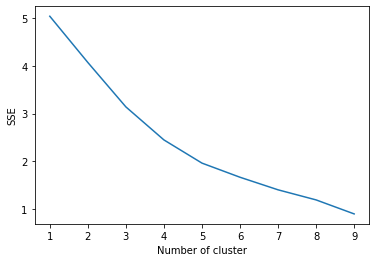

In [24]:
import matplotlib.pyplot as plt

scarborough_grouped_clustering = scarborough_grouped.drop('Neighborhood', 1)
sse={} 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=50).fit(scarborough_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [25]:
# set number of clusters
kclusters = 3

scarborough_grouped_clustering = scarborough_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0])

#### Creating a new dataframe that includes PostalCode, Neighborhood, Borough, latitude and longitude, cluster lable and top 10 common venues

In [26]:
#Dropping Upper Rouge as it doesn't have any venues from dataset
geo_data.drop(geo_data[geo_data.Neighborhood == 'Upper Rouge'].index, inplace = True)

scarborough_merged = geo_data

# adding cluster labels
scarborough_merged['Cluster Labels'] = kmeans.labels_

# merging
scarborough_merged = scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

scarborough_merged.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,2,Middle Eastern Restaurant,Shopping Mall,Breakfast Spot,Bakery,Sandwich Place,Accessories Store,Auto Garage,General Entertainment,College Stadium,Fried Chicken Joint
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,0,Skating Rink,Latin American Restaurant,Breakfast Spot,Lounge,Women's Store,College Stadium,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint
13,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,0,Pizza Place,Noodle House,Chinese Restaurant,Thai Restaurant,Gas Station,Fried Chicken Joint,Italian Restaurant,Bank,Fast Food Restaurant,Convenience Store
14,M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,0,Playground,Park,Women's Store,Chinese Restaurant,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
15,M1W,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,0,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Gym Pool,Discount Store,Pharmacy,Pizza Place,Breakfast Spot,Bank,Sandwich Place


#### Creating a map of our dataframe

In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(scarborough_merged['Latitude'], scarborough_merged['Longitude'], scarborough_merged['Neighborhood'], scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining each cluster one by one

##### Scarborough Clusters 0

In [28]:
scarborough_cluster_0 = scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 0, scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
scarborough_cluster_0

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",0,Fast Food Restaurant,Women's Store,Coffee Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Electronics Store,Discount Store
1,"Rouge Hill, Port Union, Highland Creek",0,Bar,Women's Store,Coffee Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
2,"Guildwood, Morningside, West Hill",0,Rental Car Location,Electronics Store,Medical Center,Intersection,Bank,Restaurant,Mexican Restaurant,Breakfast Spot,Convenience Store,Department Store
3,Woburn,0,Coffee Shop,Soccer Field,Korean Restaurant,Women's Store,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
4,Cedarbrae,0,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Gas Station,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Gym Pool
5,Scarborough Village,0,Women's Store,Playground,Coffee Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
6,"Kennedy Park, Ionview, East Birchmount Park",0,Chinese Restaurant,Coffee Shop,Discount Store,Department Store,Convenience Store,Hobby Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station
7,"Golden Mile, Clairlea, Oakridge",0,Bakery,Bus Line,Ice Cream Shop,Soccer Field,Intersection,Bus Station,Metro Station,Convenience Store,Grocery Store,General Entertainment
8,"Cliffside, Cliffcrest, Scarborough Village West",0,Motel,American Restaurant,Women's Store,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
10,"Dorset Park, Wexford Heights, Scarborough Town...",0,Indian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Light Rail Station,Pet Store,Coffee Shop,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant


##### Scarborough Clusters 1

In [29]:
scarborough_cluster_1 = scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 1, scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
scarborough_cluster_1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Birch Cliff, Cliffside West",1,Skating Rink,General Entertainment,Café,College Stadium,Women's Store,Coffee Shop,Gym Pool,Grocery Store,Gas Station,Fried Chicken Joint


##### Scarborough Clusters 2

In [30]:
scarborough_cluster_2 = scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 2, scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
scarborough_cluster_2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Wexford, Maryvale",2,Middle Eastern Restaurant,Shopping Mall,Breakfast Spot,Bakery,Sandwich Place,Accessories Store,Auto Garage,General Entertainment,College Stadium,Fried Chicken Joint


In [31]:
clusters=pd.DataFrame({"Cluster1":scarborough_cluster_0["Neighborhood"],
                      "Cluster2":scarborough_cluster_1["Neighborhood"],
                      "Cluster3":scarborough_cluster_2["Neighborhood"]
                      })

clusters = clusters.replace(np.nan, '', regex=True)

clusters

,Cluster1,Cluster2,Cluster3
0,"Malvern, Rouge",,
1,"Rouge Hill, Port Union, Highland Creek",,
2,"Guildwood, Morningside, West Hill",,
3,Woburn,,
4,Cedarbrae,,
5,Scarborough Village,,
6,"Kennedy Park, Ionview, East Birchmount Park",,
7,"Golden Mile, Clairlea, Oakridge",,
8,"Cliffside, Cliffcrest, Scarborough Village West",,
9,,"Birch Cliff, Cliffside West",


In [32]:
new_scarborough=scarborough_merged.set_index("Neighborhood",drop=True)
new_scarborough

,PostalCode,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,
"Malvern, Rouge",M1B,Scarborough,43.806686,-79.194353,0,Fast Food Restaurant,Women's Store,Coffee Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Electronics Store,Discount Store
"Rouge Hill, Port Union, Highland Creek",M1C,Scarborough,43.784535,-79.160497,0,Bar,Women's Store,Coffee Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
"Guildwood, Morningside, West Hill",M1E,Scarborough,43.763573,-79.188711,0,Rental Car Location,Electronics Store,Medical Center,Intersection,Bank,Restaurant,Mexican Restaurant,Breakfast Spot,Convenience Store,Department Store
Woburn,M1G,Scarborough,43.770992,-79.216917,0,Coffee Shop,Soccer Field,Korean Restaurant,Women's Store,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
Cedarbrae,M1H,Scarborough,43.773136,-79.239476,0,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Gas Station,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Gym Pool
Scarborough Village,M1J,Scarborough,43.744734,-79.239476,0,Women's Store,Playground,Coffee Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
"Kennedy Park, Ionview, East Birchmount Park",M1K,Scarborough,43.727929,-79.262029,0,Chinese Restaurant,Coffee Shop,Discount Store,Department Store,Convenience Store,Hobby Shop,Gym Pool,Grocery Store,General Entertainment,Gas Station
"Golden Mile, Clairlea, Oakridge",M1L,Scarborough,43.711112,-79.284577,0,Bakery,Bus Line,Ice Cream Shop,Soccer Field,Intersection,Bus Station,Metro Station,Convenience Store,Grocery Store,General Entertainment
"Cliffside, Cliffcrest, Scarborough Village West",M1M,Scarborough,43.716316,-79.239476,0,Motel,American Restaurant,Women's Store,Gym Pool,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store


#### Creating a dataframe for the population of Scarborough by ethinicity

In [97]:
new_scarborough_population=pd.DataFrame({
   
"White":[1246,8764,7734,1244,6556,4141,3141,6638,6638,4597,3597,1093,7618,7618,2173],
"Black":[1360,3552,3848,4188,2354,1932,6492,1592,2633,2633,1353,1356,6355,1051,1051],
"Hispanic":[4381,2089,2907,1888,1212,2318,2318,5318,9749,3949,2078, 2078,1043,1065,4851],
"Asian": [1465,2176,4775,3404,9902,1507,2210,1263,1575,1557,2098,6656,7429,1748,4512],
"Hawaiian":[5525,3857,8944,7787,3698,7068,7006,2026,9354,4193,7324,1324,1124,1324,4178],  
"Indian":[8868,3456,5566,6522,2783,1783,7083,4653,5453,6360,6366,4400,3517,3817,4657],

}
)
new_scarborough_population

,White,Black,Hispanic,Asian,Hawaiian,Indian
0,1246,1360,4381,1465,5525,8868
1,8764,3552,2089,2176,3857,3456
2,7734,3848,2907,4775,8944,5566
3,1244,4188,1888,3404,7787,6522
4,6556,2354,1212,9902,3698,2783
5,4141,1932,2318,1507,7068,1783
6,3141,6492,2318,2210,7006,7083
7,6638,1592,5318,1263,2026,4653
8,6638,2633,9749,1575,9354,5453
9,4597,2633,3949,1557,4193,6360


#### Merging the population dataframe with the neighborhood

In [98]:
new_scarborough_population["Neighborhood"]=scarborough_merged["Neighborhood"]
new_scarborough_population


,White,Black,Hispanic,Asian,Hawaiian,Indian,Neighborhood
0,1246,1360,4381,1465,5525,8868,"Malvern, Rouge"
1,8764,3552,2089,2176,3857,3456,"Rouge Hill, Port Union, Highland Creek"
2,7734,3848,2907,4775,8944,5566,"Guildwood, Morningside, West Hill"
3,1244,4188,1888,3404,7787,6522,Woburn
4,6556,2354,1212,9902,3698,2783,Cedarbrae
5,4141,1932,2318,1507,7068,1783,Scarborough Village
6,3141,6492,2318,2210,7006,7083,"Kennedy Park, Ionview, East Birchmount Park"
7,6638,1592,5318,1263,2026,4653,"Golden Mile, Clairlea, Oakridge"
8,6638,2633,9749,1575,9354,5453,"Cliffside, Cliffcrest, Scarborough Village West"
9,4597,2633,3949,1557,4193,6360,"Birch Cliff, Cliffside West"


#### Population Distribution Analysis

In [101]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as py
py.sign_in('Manisha05', 'Cham7tG8AUkFl0ywMEZz')

init_notebook_mode(connected=True) 
plt.style.use('seaborn')
x = new_scarborough_population["Neighborhood"]

y1 = new_scarborough_population["White"]
y2 = new_scarborough_population["Black"]
y3 = new_scarborough_population["Hispanic"]
y4 = new_scarborough_population["Asian"]
y5 = new_scarborough_population ["Hawaiian"]
y6 = new_scarborough_population["Indian"]

trace1 = go.Bar(
    x=x,
    y=y1,
    name="White",
    textposition = 'auto',
    marker=dict(
        color= "red",
        line=dict(
            color="red",
            width=1.5),
        ),
    opacity=0.6
)

trace2 = go.Bar(
    x=x,
    y=y2,
    name="Black",
    textposition = 'auto',
    marker=dict(
        color='blue',
        line=dict(
            color='blue',
            width=1.5),
        ),
    opacity=0.6
)

trace3 = go.Bar(
    x=x,
    y=y3,
    name="Hispanic",
    textposition = 'auto',
    marker=dict(
        color='green',
        line=dict(
            color='green',
            width=1.5),
        ),
    opacity=0.6
)

trace4 = go.Bar(
    x=x,
    y=y4,
    name="Asian",
    textposition = 'auto',
    marker=dict(
        color='yellow',
        line=dict(
            color='yellow',
            width=1.5),
        ),
    opacity=0.6
)

trace5 = go.Bar(
    x=x,
    y=y5,
    name="Hawaiian",
    textposition = 'auto',
    marker=dict(
        color='brown',
        line=dict(
            color='brown',
            width=1.5),
        ),
    opacity=0.6
)
trace6 = go.Bar(
    x=x,
    y=y6,
    name="Indian",
    textposition = 'auto',
    marker=dict(
        color='rgb(158,40,155)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

data = [trace1,trace2,trace3,trace4,trace5,trace6]

py.iplot(data, filename='grouped-bar-direct-labels')

#### School Rating Analysis

In [81]:
scarborough_school_ratings=pd.DataFrame({"Neighborhood":new_scarborough_population["Neighborhood"],
        "Top School Rating":[7,8,4,9,3,
                            2,8,8,7,4,
                            4,6,3,7,4
                            ]})
scarborough_school_ratings

,Neighborhood,Top School Rating
0,"Malvern, Rouge",7
1,"Rouge Hill, Port Union, Highland Creek",8
2,"Guildwood, Morningside, West Hill",4
3,Woburn,9
4,Cedarbrae,3
5,Scarborough Village,2
6,"Kennedy Park, Ionview, East Birchmount Park",8
7,"Golden Mile, Clairlea, Oakridge",8
8,"Cliffside, Cliffcrest, Scarborough Village West",7
9,"Birch Cliff, Cliffside West",4


#### Visualization of School rating analysis

In [82]:
scarborough_school_ratings.set_index(new_scarborough_population["Neighborhood"],inplace=True,drop=True)

In [79]:
data = [go.Bar(
            x=new_scarborough_population["Neighborhood"],
            y=[7,8,4,9,3,2,8,8,7,4,4,6,3,7,4],
     marker=dict(
        color='rgb(158,120,225)',
        line=dict(
            color='yellow',
            width=1.5,
        )
    ),
    opacity=0.6
    )]

py.iplot(data, filename='School Rating Analysis')


#### Housing Price Analysis

In [57]:
scarborough_HousingPrice=pd.DataFrame({"Neighborhood":new_scarborough_population["Neighborhood"],
                                      "Average_Housing_Price":
                                       [286600,187300,175700,225900,239440,
                                        363400,433700,233580,335200,335070,
                                        433600,233580,355060,335540,286500,
                                      ]})

In [58]:
scarborough_HousingPrice.set_index(new_scarborough_population['Neighborhood'],inplace=True,drop=True)


#### Visualization of Housing Price Analysis

In [78]:
data = [go.Bar(
            x=new_scarborough_population["Neighborhood"],
            y=[286600,187300,175700,225900,239440,363400,433700,233580,335200,335070,433600,233580,355060,335540,286500],
     marker=dict(
        color='red',
        line=dict(
            color='yellow',
            width=1.5,
        )
    ),
    opacity=0.6
    )]

py.iplot(data, filename='Housing-Price-Analysis')

#### On the basis of the above data provided let us compare two neighborhoods with the following characteristics:

##### *Having more Indian population
##### *Having high school rating
##### *Housing Price in the Range of 200k to 300k

In [60]:
first_neighborhood = input("Enter the first Neighborhood: ")
second_neighborhood = input("Enter the second Neighborhood: ")

Enter the first Neighborhood: Woburn
Enter the second Neighborhood: Cedarbrae


In [61]:
Venue_comparison=new_scarborough.loc[[first_neighborhood,second_neighborhood]].T
Venue_comparison

Neighborhood,Woburn,Cedarbrae
PostalCode,M1G,M1H
Borough,Scarborough,Scarborough
Latitude,43.771,43.7731
Longitude,-79.2169,-79.2395
Cluster Labels,0,0
1st Most Common Venue,Coffee Shop,Hakka Restaurant
2nd Most Common Venue,Soccer Field,Thai Restaurant
3rd Most Common Venue,Korean Restaurant,Athletics & Sports
4th Most Common Venue,Women's Store,Bakery
5th Most Common Venue,Grocery Store,Bank


In [108]:
new_scarborough_population["Neighborhood"]=scarborough_merged["Neighborhood"]
new_scarborough_population1=new_scarborough_population.set_index("Neighborhood")
new_scarborough_population1.head()

,White,Black,Hispanic,Asian,Hawaiian,Indian
Neighborhood,,,,,,
"Malvern, Rouge",1246,1360,4381,1465,5525,8868
"Rouge Hill, Port Union, Highland Creek",8764,3552,2089,2176,3857,3456
"Guildwood, Morningside, West Hill",7734,3848,2907,4775,8944,5566
Woburn,1244,4188,1888,3404,7787,6522
Cedarbrae,6556,2354,1212,9902,3698,2783


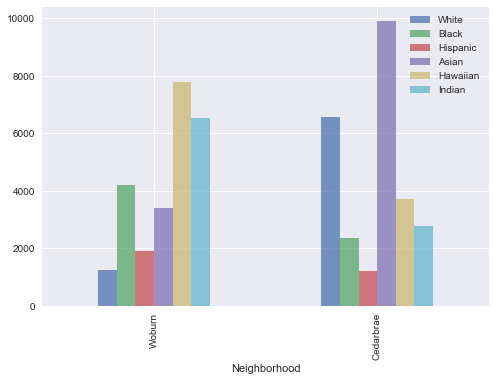

In [109]:
Population_Comparison=new_scarborough_population1.loc[[first_neighborhood,second_neighborhood]]
Population_Comparison.plot(kind='bar',alpha=0.75)
plt.show()

In [110]:
Population_Comparison['Indian']

Neighborhood
Woburn       6522
Cedarbrae    2783
Name: Indian, dtype: int64

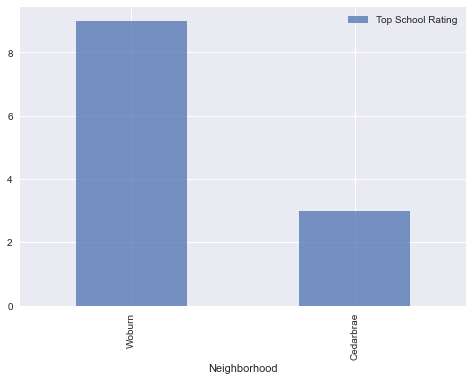

In [66]:
School_rating_comparison=scarborough_school_ratings.loc[[first_neighborhood,second_neighborhood]]
School_rating_comparison.plot(kind='bar',alpha=0.75);
plt.show()

In [67]:
School_rating_comparison

,Top School Rating
Neighborhood,
Woburn,9
Cedarbrae,3


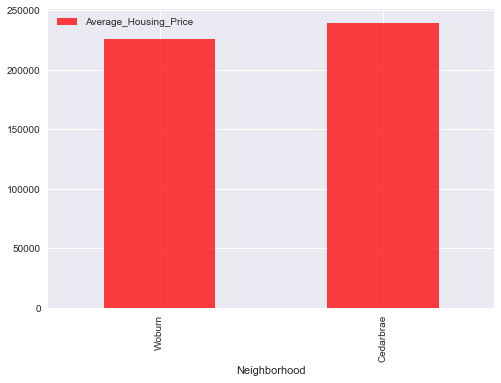

In [70]:
housing_price_comparison.plot(kind='bar',alpha=0.75,color='red');
plt.show()

In [71]:
housing_price_comparison= scarborough_HousingPrice.loc[[first_neighborhood,second_neighborhood]]
housing_price_comparison

,Neighborhood,Average_Housing_Price
Neighborhood,,
Woburn,Woburn,225900
Cedarbrae,Cedarbrae,239440


#### Conclusion

###### The above analysis of both the neighborhoods (Woburn and Cedarbrae) presents the following points:
###### *Having more Indian population: Woburn has maximum Indian population of 6522.
###### *Having high school rating: Woburn has maximum high school rating of 9.
###### *Housing Price in the Range of 200k to 300k: Both the neighborhoods have affordable house prices. However Woburn has the minimum average housing price range.